In [1]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import sys
sys.path.append('../Codes/')
from models import *
from Epi_models import*
from functions import *
import networkx as nx
import matplotlib.animation as animation
import seaborn
from matplotlib.lines import Line2D

def node_degrees(Amat):
        return Amat.sum(axis=0).reshape(N,1)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as ticker

Text_files_path = '../../../../Dropbox/Research/Epidemiology_2020/Text_files/'

%autosave 60

Autosaving every 60 seconds


## The Network
The network is generated usign the barabasi-albert algorithm. It has a heavy-tailed degree distribution characterized by a power-law behaviour and a exponential cutoff.

In [2]:
N = 2000
graphs_names = np.array(['barabasi-albert','watts-strogatz'])
nodeDegrees = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/network_degree_distrib_N%d.txt'%(N), dtype=np.int32)
meanDegree = np.mean(nodeDegrees)
meanDegree2 = np.mean(nodeDegrees**2)
degree_distrib = np.histogram(nodeDegrees, bins=range(1, max(nodeDegrees)+1), density = False)
print(max(nodeDegrees), min(nodeDegrees), meanDegree, meanDegree2)

195 1 3.996 46.88504867256637


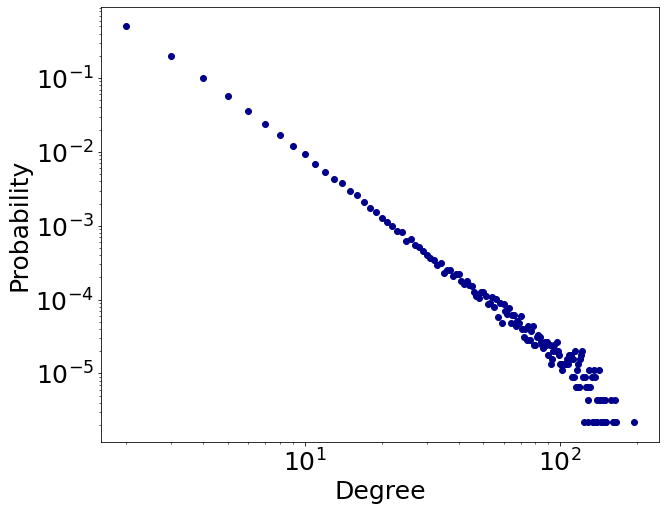

In [3]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(degree_distrib[1][1:-1], degree_distrib[0][1:]/len(nodeDegrees), 'o', color = 'darkblue')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Degree', fontsize = 25)
ax.set_ylabel('Probability', fontsize = 25)
ax.tick_params(labelsize = 25)

In [4]:
colors_R = plt.cm.Paired(range(8))
N = 2000
print('N:', N)
gamma = 1/6
print('Gamma:', gamma)
sigma = 1/4
print('Sigma:', sigma)
# I defined the R0 values for the SIR model and then get the values of beta
R0s = np.array([4.5, 3.0, 2.0, 1.2, 0.8]) #for p=1.0 I don't take into account R0=0.8
betas = R0s*gamma
print('betas:', betas)
R0_es = np.sqrt(1-4*((sigma*gamma-sigma*betas)/(sigma+gamma)**2))
Ts = 1-((meanDegree)/(meanDegree+R0s))
T_c = (meanDegree)/(meanDegree2-meanDegree)
R0_ns = Ts/T_c
print('T_c:', T_c)
print('Ts:', Ts)
print('R0s:', R0s)
print('R0_es:', R0_es)
print('R0_ns:', R0_ns)
tau = 1/gamma
tau_e = 2*(gamma+sigma)**(-1)
print('tau:', tau)
print('tau_e:', tau_e)

N: 2000
Gamma: 0.16666666666666666
Sigma: 0.25
betas: [0.75       0.5        0.33333333 0.2        0.13333333]
T_c: 0.09317063734631188
Ts: [0.52966102 0.42881647 0.3335557  0.23094688 0.16680567]
R0s: [4.5 3.  2.  1.2 0.8]
R0_es: [2.0880613  1.70880075 1.4        1.09178753 0.8988882 ]
R0_ns: [5.68484913 4.60248506 3.58005176 2.47875177 1.79032446]
tau: 6.0
tau_e: 4.800000000000001


## What is the probability of establishment?

2083
4092
6121
14483


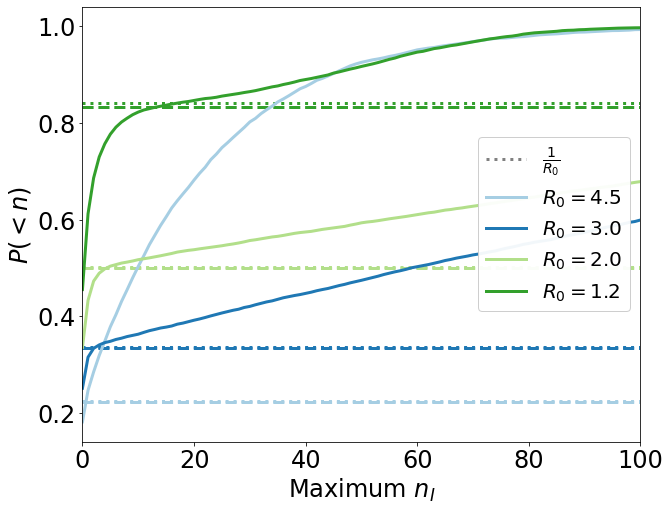

In [7]:
lines_symbols = [Line2D([0], [0], color='grey', linewidth=3, linestyle='dotted', ms = 8)]
labels_symbols = [r'$\frac{1}{R_0}$']


fig, ax = plt.subplots(figsize = (10,8))
p=1.0
sigma=1000
gamma = 1/6
if(p==0.0):
    R0s = np.array([4.5, 3.0, 2.0, 1.2, 0.8])
if(p==1.0):
    R0s = np.array([4.5, 3.0, 2.0, 1.2])    
for i, R0 in enumerate(R0s):
    data_I = np.loadtxt(Text_files_path+'Stochastic/Networks/barabasi-albert/ensemble_I_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(R0, sigma, N, p))
    data_nodes = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/stats_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(R0, sigma, N, p))
    nodes_ext , nodes_succ, I_ext, I_succ, max_values = sort_nodes(p=p, beta=R0*gamma, sigma=sigma, gamma=gamma, data_I = data_I, data_nodes = data_nodes)
    n_ext = len(nodes_ext[:,0])
    print(n_ext)
    prob_ext = n_ext/len(data_nodes[:,0])
    data_hist = numpy.histogram(max_values, bins = range(0,int(max(max_values))+2, 1), density =True);
    ax.plot(data_hist[1][:-1], np.cumsum(data_hist[0]), '-', color = colors_R[i], linewidth = 3, label = r'$R_0=$%.1f'%(R0))
    #ax.plot(data_hist[1][:-1], data_hist[0], '-', color = color_Rs[i], linewidth = 3, alpha = 0.3)
    ax.hlines(1/(R0), 0,int(max(max_values))+2, color = colors_R[i], linewidth=3, linestyle='dashed' )
    ax.hlines(prob_ext, 0,int(max(max_values))+2, color = colors_R[i], linewidth=3, linestyle='dotted' )

my_plot_layout(ax = ax, xlabel=r'Maximum $n_{{I}}$', ylabel=r'$P(<n)$')
ax.set_xlim(0, 100)
#ax.set_ylim(0, 10)
handles, labels = ax.get_legend_handles_labels()
ax.legend(np.concatenate((lines_symbols,handles)), np.concatenate((labels_symbols,labels)) , fontsize = 20, loc = 5, framealpha=.95)
#fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/maximum_ni_1_sigma_%.2f_p%.1f.pdf'%(sigma,p))


## What is the probability of epidemic as a function of $R_0$?

In [54]:
gamma = 1/6
beta_array2 = np.linspace(0.4*gamma, 6.5*gamma, 8)
u = np.linspace(0.00005,0.9,100000)
#----Load data network of contacts----
k = degree_distrib[1][:-1]
p_k = degree_distrib[0]/len(nodeDegrees)
#----Critical occupancy----
T_c = meanDegree/(meanDegree2-meanDegree)

Ts_SIR = 1-((4)/((4+((beta_array2)/(gamma)))))
Ts_SEIR = 1-((4)/((4+((beta_array2)/(gamma)))))
u_sol_SIR = np.array([u[np.array([np.sum(p_k*k*(1+(i-1)*j)**(k-1)) for i in u])>(np.sum(p_k*k)*u)][-1] for j in Ts_SIR])
u_sol_SEIR = np.array([u[np.array([np.sum(p_k*k*(1+(i-1)*j)**(k-1)) for i in u])>(np.sum(p_k*k)*u)][-1] for j in Ts_SEIR])
S_SIR = 1 - np.array([np.sum(p_k*(1+(i-1)*j)**k) for (i, j) in zip(u_sol_SIR, Ts_SIR)])
S_SEIR = 1 - np.array([np.sum(p_k*(1+(i-1)*j)**k) for (i, j) in zip(u_sol_SEIR, Ts_SEIR)])


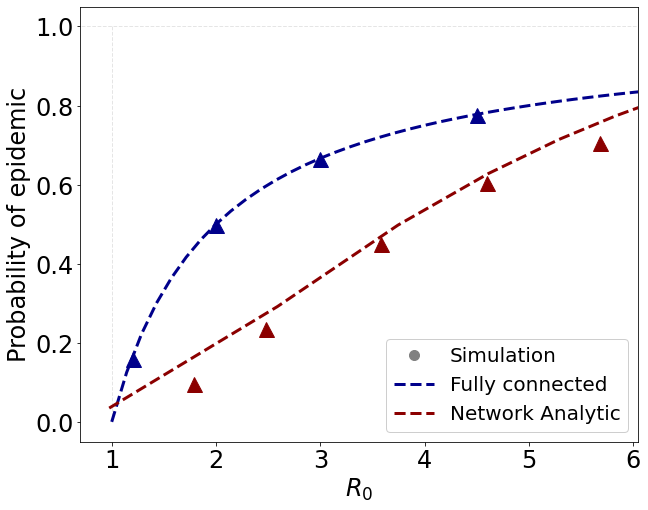

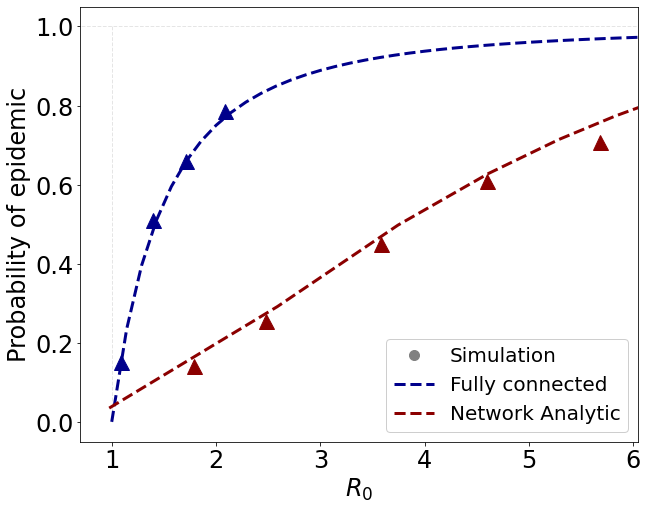

In [55]:
from scipy.stats import expon
N = 2000
ps = [1,0]
sigmas = [1000, 1/4]
gamma = 1/6
R0_array = np.linspace(1, 8, 50)
R0s_p1 = np.array([4.5, 3.0, 2.0, 1.2])
R0s_p0 = np.array([4.5, 3.0, 2.0, 1.2, 0.8])
betas1 = R0s_p1*gamma
betas2 = R0s_p0*gamma
betas_p = np.array([betas1, betas2])
R0s_SIR_p = np.array([R0s_p1, (1-((4)/((4+((betas2)/(gamma))))))/T_c])
R0s_SEIR_p = np.array([np.sqrt(1-4*(((1/4)*gamma-sigma*betas1)/((1/4)+gamma)**2)), (1-((4)/((4+((betas2)/(gamma))))))/T_c])
R0s_all = np.array([R0s_SIR_p, R0s_SEIR_p])

colors_R = plt.cm.Paired(range(7))
colors_p = ['darkblue', 'darkred']
lines_symbols = [Line2D([0], [0],linewidth = 0, color='grey', marker = '^', ms = 12)]
labels_symbols = [r'Simulation']
labels_model = ['SIR', 'SEIR']

for l, sigma in enumerate(sigmas):
    fig, ax = plt.subplots(figsize = (10,8))
    #if(sigma==1/4):
    #    ax.set_title('SEIR model', fontsize = 28)
    if(sigma==1000):
        ax.set_title('SIR model', fontsize = 28)
    R0s_p = R0s_all[l]
    for p, betas, R0s, color_p in zip(ps, betas_p, R0s_p, colors_p):
        
        p_epi_array = np.array([])
        
        for beta, R0, color in zip(betas, R0s, colors_R):
            #----Edge Occupancy probability----

            tau = 1/gamma
            data_nodes = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/stats_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(beta/gamma, sigma, N, p))
            data_I = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/ensemble_I_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(beta/gamma, sigma, N, p))
            nodes_ext , nodes_succ, I_ext, I_succ, max_values = sort_nodes(p=p, beta=beta, sigma=sigma, gamma=gamma, data_I = data_I, data_nodes = data_nodes)
            
            if(sigma==1/4):
                tau = 2*((gamma)+(sigma))**(-1)
            s = ((R0)-1)
            
            #n_epi = len(max_values[max_values>(1/(s/tau))])
            #n_ext = len(max_values[max_values<(1/(s/tau))])
            
            n_epi = len(nodes_succ[:,0])
            n_ext = len(nodes_ext[:,0])
            
            n_total = n_epi + n_ext
            p_epi_array = np.append(p_epi_array, (n_epi)/n_total)
        
        
        ax.plot(R0s, p_epi_array, marker = '^', color = color_p, ms = 15, linestyle = '')
        
        if(p==1.0):
            if(sigma==1000):
                ax.plot(R0_array, 1-((1/R0_array)),linestyle = 'dashed', linewidth = 3, color = color_p, label = 'Fully connected')
            if(sigma==1/4):
                ax.plot(R0_array, 1-((1/R0_array)**2),linestyle = 'dashed', linewidth = 3, color = color_p, label = 'Fully connected')
        if(p==0.0):
            if(sigma==1000):
                R0_N_array2 = Ts_SIR/T_c
                ax.plot(R0_N_array2, S_SIR ,linestyle = 'dashed', linewidth = 3, color = color_p, label = r'Network Analytic')
            if(sigma==1/4):
                R0_N_array2 = Ts_SEIR/T_c
                ax.plot(R0_N_array2, S_SEIR ,linestyle = 'dashed', linewidth = 3, color = color_p, label = r'Network Analytic')
        
    ax.hlines(1,0.5,6.5, linestyle = 'dashed', color = 'silver', alpha = .4, linewidth = 1)
    ax.vlines(1,0,1, linestyle = 'dashed', color = 'silver', alpha = .4, linewidth = 1)
    my_plot_layout(ax=ax, xlabel = r'$R_0$', ylabel=r'Probability of epidemic')
    ax.set_xlim(0.7,6.05)
    ax.set_ylim(-0.05, 1.05)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(np.concatenate((lines_symbols,handles)), np.concatenate((labels_symbols,labels)) , fontsize = 20, loc = 4, framealpha=.95)
    fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/Prob_epi_'+labels_model[l]+'.pdf')


## How does the probability of epidemic depends on the outbreak size?

# SIR

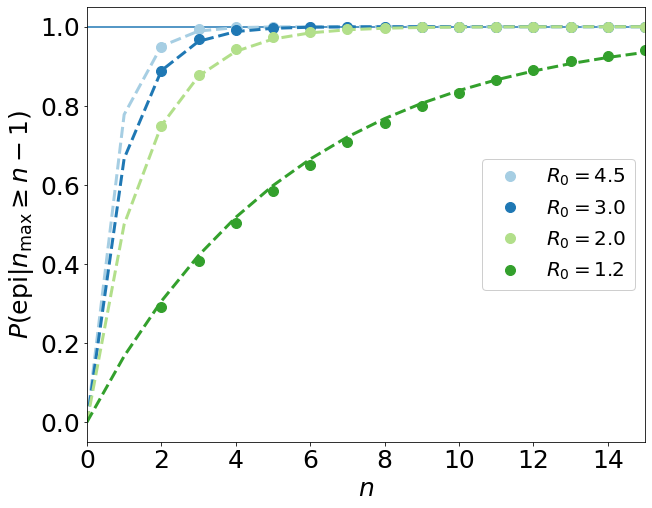

In [65]:
fig, ax = plt.subplots(figsize = (10,8))
p=1.0
sigma=1000
if(p==0.0):
    R0s = np.array([4.5, 3.0, 2.0, 1.2, 0.8])
if(p==1.0):
    R0s = np.array([4.5, 3.0, 2.0, 1.2])
prob_epi_ns = np.empty(20)
for i, R0 in enumerate(R0s):
    prob_epi_n_temp = np.ones(50)
    data = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/ensemble_I_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(R0, sigma, N, p))
    max_values = np.array([np.max(data[i,:]) for i in np.arange(len(data[:,0]))])
    data_ext = [((data[i,-1]==0) & (max_values[i] < 20)) for i in np.arange(len(data[:,0]))] #selecting extinct trajectories
    n_ext = len(data[:,0][data_ext])
    prob_ext = n_ext/len(data[:,0])
    data_hist = numpy.histogram(max_values, bins = np.arange(0,int(np.max(max_values))+2, 1), density = True);
    data_hist_ext = numpy.histogram(max_values[data_ext], bins = np.arange(0,int(np.max(max_values))+2, 1), density = True);

    prob_epi_n = 1-(((1-np.cumsum(data_hist_ext[0]))*prob_ext)/(1-np.cumsum(data_hist[0])[data_hist_ext[1][:-1]]))
    prob_epi_ns = np.vstack((prob_epi_ns, prob_epi_n[:20]))
    ax.plot(data_hist_ext[1][:-1]+2, prob_epi_n , 'o', color = colors_R[i], ms = 10,  label = r'$R_0=$%.1f'%(R0))
    #ax.plot(np.array(range(20)), 1-(prob_ext)**(np.array(range(20))),linewidth = 3, color = colors_R[i])
    ax.plot(np.array(np.arange(20)), 1-(1/R0)**(np.array(np.arange(20))),linewidth = 3, linestyle = '--', color = colors_R[i])
ax.hlines(1,0,40)
ax.set_xticks(np.array(np.arange(0,20,2)))
ax.set_xlabel(r'$n$', fontsize = 25)
ax.set_ylabel(r'$P(\mathrm{epi}|n_{\mathrm{max}}\geq n-1)$', fontsize = 25)
ax.set_xlim(0, 15)
ax.set_ylim(-0.05, 1.05)
#ax.set_yscale('log')
ax.tick_params(labelsize = 25)
handles, labels = ax.get_legend_handles_labels()
ax.legend(np.concatenate(([],handles)), np.concatenate(([],labels)) , fontsize = 20, loc = 5, framealpha=.95)
fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/epi_prob_nmax_SIR_n_data_p%.1f.pdf'%(p))
fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/epi_prob_nmax_SIR_n_data_p%.1f.png'%(p))


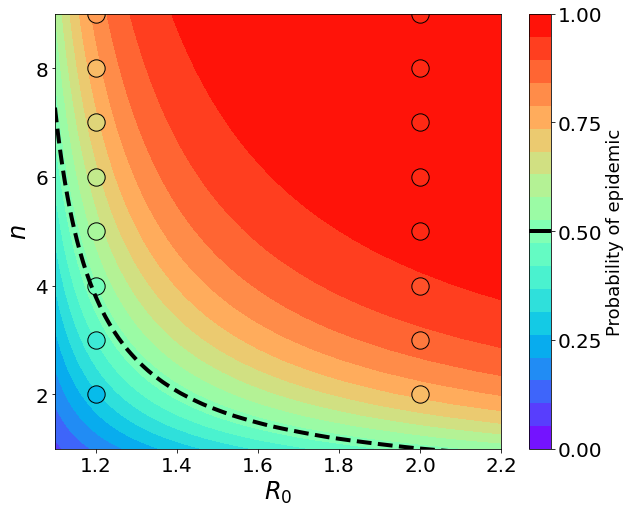

In [66]:
R0s = np.linspace(1.1, 5, 500)
ns = np.linspace(0, 20, 100)
R0s_data = np.array([4.5, 3.0, 2.0, 1.2])
ns_data = np.linspace(0, 19, 20)
x, y = np.meshgrid(R0s, ns)
z = 1-(1/x)**(y)
fig, ax = plt.subplots(figsize = (10,8))
cs = ax.contourf(x, y, z, levels = np.linspace(0,1,20), cmap = plt.cm.rainbow)
cs2 = ax.contour(cs, levels=[0.5], colors='k', linestyles = 'dashed', linewidths = 4)
for i in np.arange(len(R0s_data)):
    for j in np.arange(len(ns_data)):
        #print(int(100*prob_epi_ns[1:,:][i,j]))
        #print(plt.cm.rainbow(np.linspace(0,1,200))[int(199*prob_epi_ns[1:,:][i,j])])
        ax.scatter(R0s_data[i], ns_data[j]+2, color = plt.cm.rainbow(np.linspace(0,1,20))[int(19*prob_epi_ns[1:,:][i,j])], s = 300, edgecolors='k')
ax.set_yticks(np.arange(0,20,2))
ax.set_xlim(1.1,2.2)
ax.set_ylim(1,9)
ax.set_xlabel(r'$R_0$', fontsize = 24)
ax.set_ylabel(r'$n$', fontsize = 24)
ax.tick_params(labelsize = 20)
cbar = fig.colorbar(cs, ticks=np.linspace(0,1,5))
cbar.ax.set_yticks(np.arange(2))
cbar.ax.set_ylabel('Probability of epidemic', fontsize = 18)
#cbar.ax.set_yticklabels(np.linspace(0,1,5))
cbar.ax.tick_params(labelsize = 20)
cbar.add_lines(cs2)
fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/Epi_prob_n_SIR_R0_p%.1f.pdf'%(p))
fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/Epi_prob_n_SIR_R0_p%.1f.png'%(p))


# SEIR

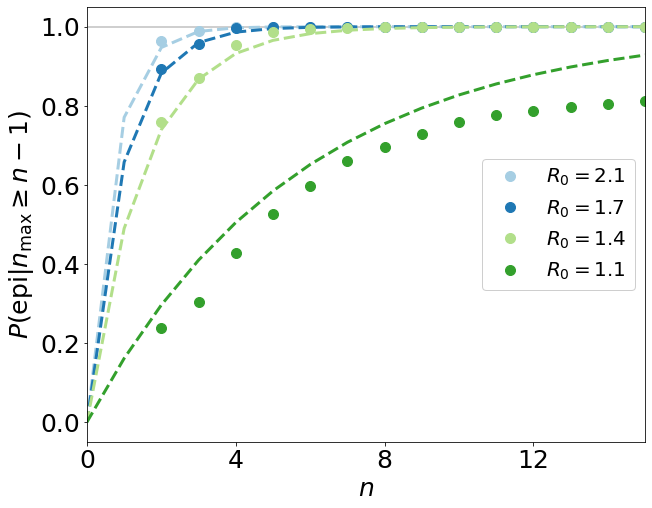

In [67]:
fig, ax = plt.subplots(figsize = (10,8))
colors = plt.cm.Paired(np.arange(7))
p=1.0
sigma=1/4

if(p==0.0):
    R0s = np.array([4.5, 3.0, 2.0, 1.2, 0.8])
if(p==1.0):
    R0s = np.array([4.5, 3.0, 2.0, 1.2])
       
prob_epi_ns = np.empty(20)
for i, R0 in enumerate(R0s):
    beta = R0*gamma
    growth_exp = ((-sigma-gamma)/(2)) + (1/2)*np.sqrt((sigma-gamma)**2 + 4*sigma*beta)
    n_est = 1/growth_exp
    data = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/ensemble_I_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(R0, sigma, N, p))
    R0 = np.sqrt(1-4*((sigma*gamma-sigma*beta)/(sigma+gamma)**2))
    max_values = np.array([np.max(data[i,:]) for i in np.arange(len(data[:,0]))])
    data_ext = [((data[i,-1]==0) & (max_values[i] <= (n_est))) for i in np.arange(len(data[:,0]))]
    n_ext = len(data[:,0][data_ext])
    prob_ext = n_ext/len(data[:,0])
    data_hist = numpy.histogram(max_values, bins = np.arange(0,int(np.max(max_values))+2, 1), density =True);
    data_hist_ext = numpy.histogram(max_values, bins = np.arange(0,data_hist[1][:-1][np.cumsum(data_hist[0])<=prob_ext][-1]+2, 1), density =True);
    data_hist_ext = numpy.histogram(max_values[data_ext], bins = np.arange(0,int(np.max(max_values))+2, 1), density = True);

    #ax.plot(data_hist_ext[1][:-1], ((data_hist_ext[0]*1)/1), '-', color = colors[i], linewidth = 3, label = r'$R_0=$%.1f'%(R0))
    prob_epi_n = 1-(((1-np.cumsum(data_hist_ext[0]))*prob_ext)/(1-np.cumsum(data_hist[0])[data_hist_ext[1][:-1]]))
    #shape = np.shape(prob_epi_n)
    #prob_epi_n_temp[:shape[0]]=prob_epi_n
    prob_epi_ns = np.vstack((prob_epi_ns, prob_epi_n[:20]))
    ax.plot(data_hist_ext[1][:-1]+2, prob_epi_n , 'o', color = colors[i], ms = 10,  label = r'$R_0=$%.1f'%(R0))
    #ax.plot(np.array(range(20)), 1-(prob_ext)**(2*np.array(range(20))),linewidth = 3, color = colors[i])
    ax.plot(np.array(np.arange(20)), 1-(1/R0)**(2*np.array(np.arange(20))),linewidth = 3, linestyle = '--', color = colors_R[i])

ax.hlines(1,0,40, color = 'silver')
ax.set_xticks(np.array(np.arange(0,20,4)))
ax.set_xlabel(r'$n$', fontsize = 25)
ax.set_ylabel(r'$P(\mathrm{epi}|n_{\mathrm{max}}\geq n-1)$', fontsize = 25)
ax.set_xlim(0, 15)
ax.set_ylim(-0.05, 1.05)
#ax.set_yscale('log')
ax.tick_params(labelsize = 25)
handles, labels = ax.get_legend_handles_labels()
ax.legend(np.concatenate(([],handles)), np.concatenate(([],labels)) , fontsize = 20, loc = 5, framealpha=.95)
fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/epi_prob_nmax_SEIR_n_data_p%.1f.pdf'%(p))
fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/epi_prob_nmax_SEIR_n_data_p%.1f.png'%(p))



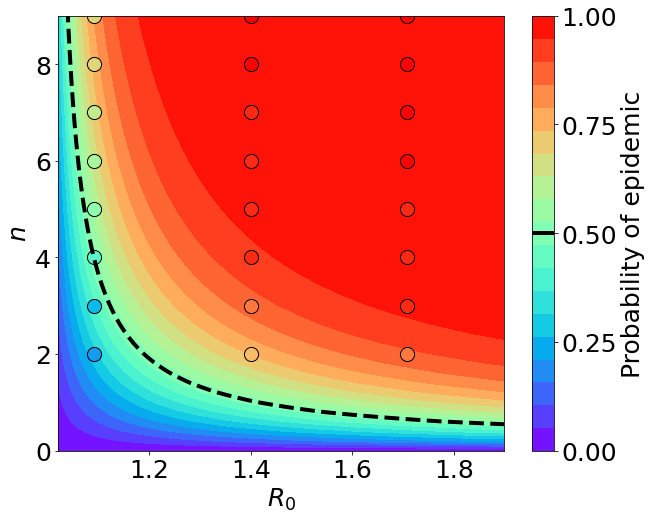

In [68]:
R0s = np.linspace(1.02, 2.5, 500)
ns = np.linspace(0, 20, 100)
R0s_data = np.array([4.5, 3.0, 2.0, 1.2])
betas = R0s_data*gamma
R0s_data = np.sqrt(1-4*((sigma*gamma-sigma*betas)/(sigma+gamma)**2))
ns_data = np.linspace(0, 19, 20)
x, y = np.meshgrid(R0s, ns)
z = 1-(1/(x)**2)**(y)
fig, ax = plt.subplots(figsize = (10,8))
cs = ax.contourf(x, y, z, levels = np.linspace(0,1,20), cmap = plt.cm.rainbow)
cs2 = ax.contour(cs, levels=[0.5], colors='k', linestyles = 'dashed', linewidths = 4)
for i in range(len(R0s_data)):
    for j in range(len(ns_data)):
        #print(int(100*prob_epi_ns[1:,:][i,j]))
        #print(plt.cm.rainbow(np.linspace(0,1,200))[int(199*prob_epi_ns[1:,:][i,j])])
        ax.scatter(R0s_data[i], ns_data[j]+2, color = plt.cm.rainbow(np.linspace(0,1,20))[int(19*prob_epi_ns[1:,:][i,j])], s = 200, edgecolors='k')
ax.set_yticks(range(0,20,2))
ax.set_xlim(1.02,1.9)
ax.set_ylim(0, 9)
ax.set_xlabel(r'$R_0$', fontsize = 25)
ax.set_ylabel(r'$n$', fontsize = 25)
ax.tick_params(labelsize = 25)
cbar = fig.colorbar(cs, ticks=np.linspace(0,1,5))
cbar.ax.set_yticks(np.arange(2))
cbar.ax.set_ylabel('Probability of epidemic', fontsize = 25)
#cbar.ax.set_yticklabels(np.linspace(0,1,5))
cbar.ax.tick_params(labelsize = 25)
cbar.add_lines(cs2)
fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/Epi_prob_n_SEIR_R0_p%.1f.pdf'%(p))
fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/Epi_prob_n_SEIR_R0_p%.1f.png'%(p))



# How does the probability of epidemic depends on the degree of patient zero?

# SIR

0.0064224137931034484


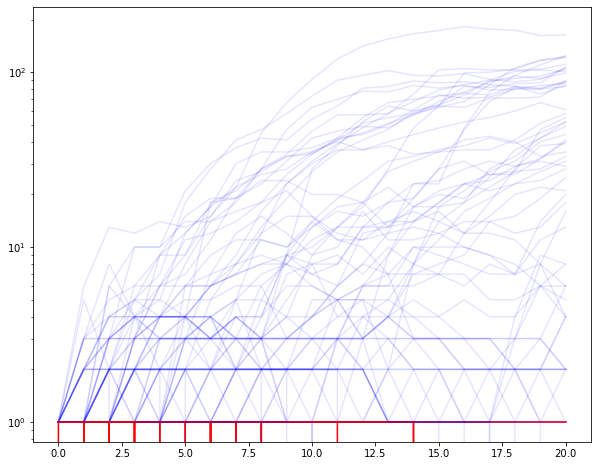

In [70]:
fig, ax = plt.subplots(figsize = (10,8))
R0=1.2
data = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/ensemble_I_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(R0, 1000, N, 0))
counter = 0 
for i in np.arange(0,int(len(data[:,0])),100):
    if(data[i,-1]<2 and (np.max(data[i,:])<2)):
        counter+=1
        color = 'r'
        alpha = 1
    else:
        color = 'b'
        alpha = .1
    ax.plot(data[i,:], color = color, alpha = alpha);
ax.set_yscale('log')
print(counter/len(data[:,0]))


1.7155706795696049
u: 0.2416979909799098
3.001499500415834
u: 0.3333678146781468
6.001999666831056
u: 0.44692464124641246
30.005999800031034
u: 0.6147219967199672


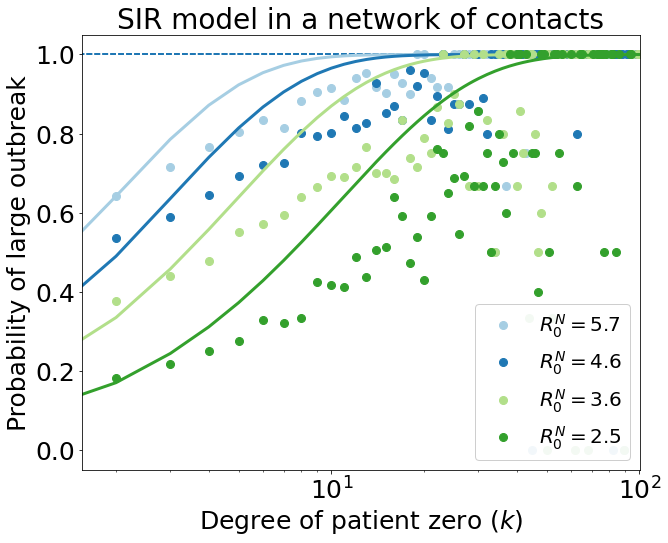

In [71]:
from scipy.stats import expon
from scipy.special import gamma, gammaincc, exp1
def inc_gamma(a, x):
    return exp1(x) if a == 0 else gamma(a)*gammaincc(a, x)

lines_symbols = [Line2D([0], [0], color='grey', linewidth=3, linestyle='--', ms = 8)]
labels_symbols = [r'A/F $1-\frac{1}{R0}$']

sigma = 1000
p=0.0
gamma = 1/6
R0s = np.array([4.5, 3.0, 2.0, 1.2])
R0s2 = np.array([4.5, 3.0, 2.0, 1.2])
#R0s2 = np.array([2.0, 1.2, 0.8])
if(p==0.0):
    betas = R0s2*gamma
if(p==1.0):
    betas = R0s*gamma

u = np.linspace(0.00005,0.9,100000)
prob_epi_ns = np.empty(20)
#----Critical occupancy----
T_c = meanDegree/(meanDegree2-meanDegree)
#print('T_c:',T_c, '\n')

#----Load data network of contacts----

k = degree_distrib[1][:-1]
p_k = degree_distrib[0]/len(nodeDegrees)

#----o----

fig, ax = plt.subplots(figsize = (10,8))


if(p==1.0):
    ax.set_title('SIR Fully connected model', fontsize = 28)
if(p==0.0):
    ax.set_title('SIR model in a network of contacts', fontsize = 28)

for beta, color, in zip(betas, colors_R):
    growth_exp = ((-sigma-gamma)/(2)) + (1/2)*np.sqrt((sigma-gamma)**2 + 4*sigma*beta)
    n_est = np.max((1, 1/growth_exp))
    print(n_est)
    #----Edge Occupancy probability----
    #T = 1-sum(p_k*((4)/((4+((beta*k)/(gamma))))))/(sum(p_k))
    T = 1- ((meanDegree)/((meanDegree + ((beta)/(gamma)))))
    T = 1 - np.sum(p_k*(4/(4+((beta)/(gamma)))))
    #T = ((beta)/(4*gamma))*np.exp(((beta)/(4*gamma)))*inc_gamma(0.0, beta/(4*gamma))
    
    #----Reproductive number----
    if(p==1.0):
        R0 = beta/gamma
    if(p==0.0):
        R0 = T/T_c
    #----Epidemic probability as a function of degree of patient zero----  
    if(p==0.0):
        u_sol = u[np.array([np.sum(p_k*k*(1+(i-1)*T)**(k-1)) for i in u])>(np.sum(p_k*k)*u)][-1]
        print('u:', u_sol)
        e_k = 1-(1-T+(T*u_sol))**k

    
    #----Load data with simulation outcomes----
    data_stats = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/stats_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(beta/gamma, sigma, N, p))
    data_I = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/ensemble_I_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(beta/gamma, sigma, N, p))
    max_values = np.array([np.max(data_I[i,:]) for i in range(len(data_I[:,0]))])
    
    #data_ext = np.array([((data_I[i,-1]==0) & (max(data_I[i,:]) < 15)) for i in range(len(data_I[:,0]))])
    data_ext = np.array([((data_I[i,-1]==0) and (max_values[i]<n_est)) for i in np.arange(len(data_I[:,0]))])
    #data_ext = np.array([((np.max(data_I[i,:])<.5*n_est)) for i in range(len(data_I[:,0]))])
    
    degrees_epi, counts_epi = np.unique(data_stats[:,0][~data_ext], return_counts=True)
    degrees_ext, counts_ext = np.unique(data_stats[:,0][data_ext], return_counts=True)
    
    max_degree = np.max(np.concatenate((degrees_epi, degrees_ext)))
    degrees = np.array(np.arange(1,int(max_degree)))
    e_k_data = np.array([])
    n_epi = 0
    n_ext = 0
    
    for d in degrees[:]:
        n_epi = max(0, counts_epi[degrees_epi==d])
        n_ext = max(0, counts_ext[degrees_ext==d])
        #n_no_epi += max(len(counts_no_epi[degrees_no_epi==d]), counts_no_epi[degrees_no_epi==d])
        n_total = n_epi + n_ext
        if(n_total>0):
            e_k_data = np.append(e_k_data, (n_epi)/n_total)
        else:
            degrees = degrees[~np.isin(degrees, d)]
    prob_epi_ns = np.vstack((prob_epi_ns, e_k_data[:20]))
    #----Plot e_k----
    ax.hlines(1,1,np.max(degrees)*1.1, linestyle = 'dashed')
    if(p==1.0):
        ax.plot(degrees, e_k_data, 'o', color = color, ms = 8, label = r'$R_0=%.1f$'%(R0))
        #ax.hlines(fixation_prob(1/N, s, N), 1, max_degree , color = color, linewidth = 3, alpha = 0.2)
        ax.hlines(1-(1/R0), 1, max_degree , color = color, linestyle = 'dashed', linewidth = 3)
    if(p==0.0):
        ax.plot(degrees, e_k_data, 'o', color = color, ms = 8, label = r'$R_0^N=%.1f$'%(R0))
        ax.plot(k, e_k, color = color, linewidth = 3)        
    #for i in range(100):
    #    ax2.plot(data_I[i, :], color = plt.cm.rainbow(np.linspace(0,1,int(max_degree+1)))[int(data_stats[i,0])], alpha = .5)
        
ax.set_xticks(np.array(np.arange(0,int(max_degree),4)))
ax.set_xlabel(r'Degree of patient zero $(k)$', fontsize = 25)
ax.set_ylabel(r'Probability of large outbreak', fontsize = 25)
ax.tick_params(labelsize = 25)
ax.set_xlim(1.55, 100.5)
ax.set_ylim(-0.05, 1.05)
ax.set_xscale('log')

if(p==1.0):
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(np.concatenate((lines_symbols,handles)), np.concatenate((labels_symbols,labels)) , fontsize = 20, loc = 4, framealpha=.95)
if(p==0.0):
    ax.legend(fontsize = 20, loc = 4, framealpha=.95)
#fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/prob_epi_k_p%.1f.pdf'%(p))

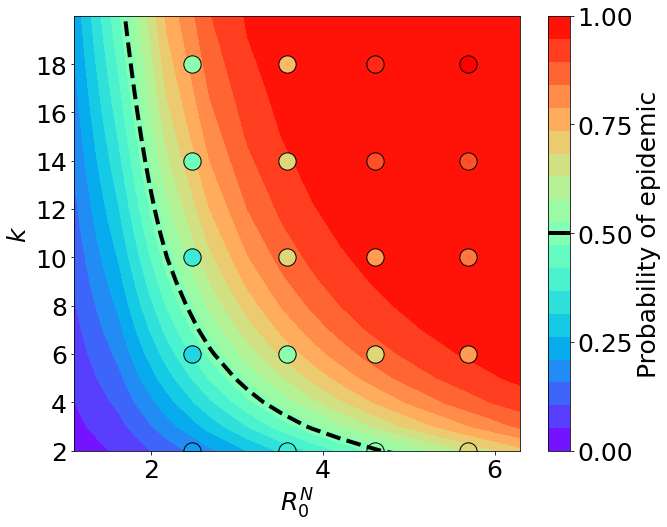

In [72]:
R0s = np.linspace(0.4, 6.3, 20)
ns = np.linspace(0, 20, 100)
R0s_data = np.array([4.5, 3.0, 2.0, 1.2])
#R0s_data = np.array([2.0, 1.2, 0.8])
T_c = meanDegree/(meanDegree2-meanDegree)
Ts = 1-((meanDegree)/((meanDegree+(R0s))))
Ts_data = 1-((meanDegree)/((meanDegree+(R0s_data))))
R0_Ns = Ts/T_c
R0_Ns_data = Ts_data/T_c
u = np.linspace(0.00005,0.9,100000)
u_sols = np.array([u[np.array([np.sum(p_k*k*(1+(i-1)*T)**(k-1)) for i in u])>(np.sum(p_k*k)*u)][-1] for T in Ts])
x, y = np.meshgrid(R0_Ns, k[:25])
x2, y2 = np.meshgrid(R0_Ns, p_k[:25])
x3, y3 = np.meshgrid(u_sols, k[:25])
z = 1-(1-(x*T_c)+((x*T_c)*x3))**y

p = 0.0

fig, ax = plt.subplots(figsize = (10,8))
cs = ax.contourf(x, y, z, levels = np.linspace(0,1,20), cmap = plt.cm.rainbow)
cs2 = ax.contour(cs, levels=[0.5], colors='k', linestyles = 'dashed', linewidths = 4)
for i in np.arange(len(R0_Ns_data)):
    for j in np.arange(1, 20, 4):
        ax.scatter(R0_Ns_data[i], k[j], color = plt.cm.rainbow(np.linspace(0,1,20))[int(19*prob_epi_ns[1:,:][i,j])], s = 300, edgecolors='k')
ax.set_yticks(np.arange(0,20,2))
ax.set_xlim(1.1,6.3)
ax.set_ylim(2,20)
ax.set_xlabel(r'$R^N_0$', fontsize = 25)
ax.set_ylabel(r'$k$', fontsize = 25)
ax.tick_params(labelsize = 25)
cbar = fig.colorbar(cs, ticks=np.linspace(0,1,5))
cbar.ax.set_yticks(np.arange(2))
cbar.ax.set_ylabel('Probability of epidemic', fontsize = 25)
#cbar.ax.set_yticklabels(np.linspace(0,1,5))
cbar.ax.tick_params(labelsize = 25)
cbar.add_lines(cs2)
#fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/Epi_prob_n_SIR_R0_p%.1f.pdf'%(p))
#fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/Epi_prob_n_SIR_R0_p%.1f.png'%(p))


# SEIR

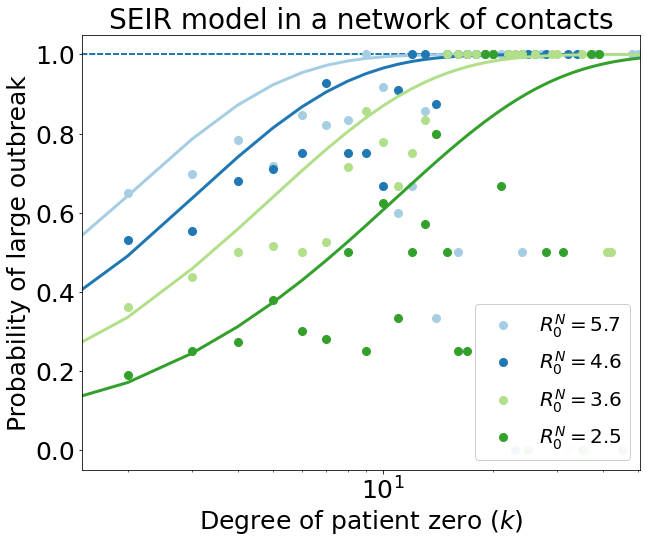

In [74]:
from scipy.stats import expon
from scipy.special import gamma, gammaincc, exp1
def inc_gamma(a, x):
    return exp1(x) if a == 0 else gamma(a)*gammaincc(a, x)

lines_symbols = [Line2D([0], [0], color='grey', linewidth=3, linestyle='--', ms = 8)]
labels_symbols = [r'A/F $1-\frac{1}{R0}$']

N = 2000
sigma = 1/4
gamma = 1/6
p=0.0
R0s = np.array([4.5, 3.0, 2.0, 1.2])
R0s2 = np.array([4.5, 3.0, 2.0, 1.2])
if(p==0.0):
    betas = R0s2*gamma
if(p==1.0):
    betas = R0s*gamma
colors_R = plt.cm.Paired(range(6))
u = np.linspace(0.00005,0.9,100000)

#----Critical occupancy----
T_c = meanDegree/(meanDegree2-meanDegree)
#print('T_c:',T_c, '\n')

#----Load data network of contacts----
k = degree_distrib[1][:-1]
p_k = degree_distrib[0]
#----o----

fig, ax = plt.subplots(figsize = (10,8))
if(p==1.0):
    ax.set_title('SEIR Fully connected model', fontsize = 28)
if(p==0.0):
    ax.set_title('SEIR model in a network of contacts', fontsize = 28)

for beta, color, in zip(betas, colors_R):
    growth_exp = ((-sigma-gamma)/(2)) + (1/2)*np.sqrt((sigma-gamma)**2 + 4*sigma*beta)
    n_est = np.max((1, 1/growth_exp))
    #----Edge Occupancy probability----
    #T = 1-sum(p_k*((4)/((4+((beta*k)/(gamma))))))/(sum(p_k))
    T = 1-((meanDegree)/((meanDegree+((beta)/(gamma)))))
    #T = 1-((meanDegree)/((meanDegree+(np.sqrt(1-4*((sigma*gamma-sigma*beta)/(sigma+gamma)**2))))))
    #T = ((beta)/(4*gamma))*np.exp(((beta)/(4*gamma)))*inc_gamma(0.0, beta/(4*gamma))
    
    #----Reproductive number----
    if(p==1.0):
        R0 = np.sqrt(1-4*((sigma*gamma-sigma*beta)/(sigma+gamma)**2))
    if(p==0.0):
        R0 = T/T_c
    #----Epidemic probability as a function of degree of patient zero----  
    if(p==0.0):
        u_sol = u[np.array([np.sum(p_k*k*(1+(i-1)*T)**(k-1)) for i in u])>(np.sum(p_k*k)*u)][-1]
        e_k = 1-(1-T+(T*u_sol))**k


    #----Load data with simulation outcomes----
    data_stats = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/stats_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(beta/gamma, sigma, N, p))
    data_I = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/ensemble_I_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(beta/gamma, sigma, N, p))
    max_values = np.array([np.max(data_I[i,:]) for i in range(len(data_I[:,0]))])
    
    data_ext = np.array([((data_I[i,-1]==0) & (max_values[i] < n_est)) for i in np.arange(len(data_I[:,0]))])
    
    degrees_epi, counts_epi = np.unique(data_stats[:,0][~data_ext], return_counts=True)
    degrees_ext, counts_ext = np.unique(data_stats[:,0][data_ext], return_counts=True)
    max_degree = np.max(np.concatenate((degrees_epi, degrees_ext)))
    degrees = np.array(np.arange(2,int(max_degree)))
    e_k_data = np.array([])
    for d in degrees:
        n_epi = max(len(counts_epi[degrees_epi==d]), counts_epi[degrees_epi==d])
        n_ext = max(len(counts_ext[degrees_ext==d]), counts_ext[degrees_ext==d])
        #n_no_epi += max(len(counts_no_epi[degrees_no_epi==d]), counts_no_epi[degrees_no_epi==d])
        n_total = n_epi + n_ext
        if(n_total>0):
            e_k_data = np.append(e_k_data, (n_epi)/n_total)
        else:
            temp = np.isin(degrees, d)
            degrees = degrees[~temp]
    
    #----Plot e_k----
    ax.hlines(1,1,np.max(degrees)*1.1, linestyle = 'dashed')
    if(p==1.0):
        ax.plot(degrees, e_k_data, 'o', color = color, ms = 8, label = r'$R_0=%.1f$'%(R0))
        #ax.hlines(fixation_prob(1/N, s, N), 1, max_degree , color = color, linewidth = 3, alpha = 0.2)
        ax.hlines(1-(1/R0)**2, 1, max_degree , color = color, linestyle = 'dashed', linewidth = 3)
    if(p==0.0):
        ax.plot(degrees, e_k_data, 'o', color = color, ms = 8, label = r'$R_0^N=%.1f$'%(R0))
        ax.plot(k, e_k, color = color, linewidth = 3)        

ax.set_xticks(np.array(np.arange(0,int(max_degree),2)))
ax.set_xlabel(r'Degree of patient zero $(k)$', fontsize = 25)
ax.set_ylabel(r'Probability of large outbreak', fontsize = 25)
ax.tick_params(labelsize = 25)
ax.set_xlim(1.5, 50.5)
ax.set_ylim(-0.05, 1.05)
ax.set_xscale('log')

if(p==1.0):
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(np.concatenate((lines_symbols,handles)), np.concatenate((labels_symbols,labels)) , fontsize = 20, loc = 4, framealpha=.95)
if(p==0.0):
    ax.legend(fontsize = 20, loc = 4, framealpha=.95)
#fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/prob_epi_k_p%.1f.pdf'%(p))

In [16]:
print(np.array((range(2, 25, 4))))

[ 2  6 10 14 18 22]


## What is $\log{L} = \log{\left(\frac{p(epi|k)}{p(epi)}\right)} $ as a function of $k$?

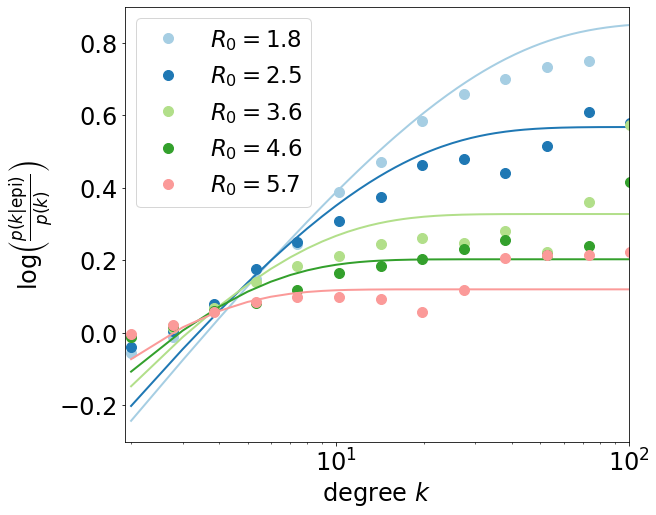

In [86]:
G_name = 'barabasi-albert'
p=0.0
gamma = 1/6
sigma=1000
beta_array = np.array([0.8, 1.2, 2.0, 3.0, 4.5])*gamma
u = np.linspace(0.00005,0.9,100000)
#----Load data network of contacts----
k = degree_distrib[1][1:-1]
p_k = degree_distrib[0][1:]/len(nodeDegrees)
#----Critical occupancy----
T_c = meanDegree/(meanDegree2-meanDegree)
Ts_SIR = 1-((4)/((4+((beta_array)/(gamma)))))

colors_R = plt.cm.Paired(np.arange(5))

fig2, ax2 = plt.subplots(figsize = (10,8), gridspec_kw={'left':.2})
fig, ax = plt.subplots(figsize = (10,8), gridspec_kw={'left':.2})

like_deg_power10 = np.array([])
like_deg_power_err10 = np.array([])

like_deg_power00 = np.array([])
like_deg_power_err00 = np.array([])

surv_prob_p10 = np.array([])
surv_prob_p00 = np.array([])

max_degree_fit = 40

data = ax2.hist(nodeDegrees, cumulative= True, bins=np.logspace(np.log10(2), np.log10(np.max(nodeDegrees)), 15), density = True, alpha = .2)

#Ts_SEIR = 1-((4)/((4+((beta_array2)/(gamma)))))
u_sol_SIR = np.array([u[np.array([np.sum(p_k*k*(1+(i-1)*j)**(k-1)) for i in u])>(np.sum(p_k*k)*u)][-1] for j in Ts_SIR])
#u_sol_SEIR = np.array([u[np.array([np.sum(p_k*k*(1+(i-1)*j)**(k-1)) for i in u])>(np.sum(p_k*k)*u)][-1] for j in Ts_SEIR])
S_SIR = 1 - np.array([np.sum(p_k*(1+(i-1)*j)**k) for (i, j) in zip(u_sol_SIR, Ts_SIR)])
#S_SEIR = 1 - np.array([np.sum(p_k*(1+(i-1)*j)**k) for (i, j) in zip(u_sol_SEIR, Ts_SEIR)])

for l, beta in enumerate(beta_array):
    u_sol = u[np.array([np.sum(p_k*k*(1+(i-1)*Ts_SIR[l])**(k-1)) for i in u])>(np.sum(p_k*k)*u)][-1]
    e_k = 1-(1-Ts_SIR[l]+(Ts_SIR[l]*u_sol))**k
    ax.plot(k, np.log10(e_k/S_SIR[l]), color = colors_R[l], linestyle = '-', linewidth = 2)
    
    
    #----Load data with simulation outcomes----
    data_stats = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/stats_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(beta/gamma, sigma, N, p))
    data_I = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/ensemble_I_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(beta/gamma, sigma, N, p))

    max_values = np.array([np.max(data_I[i,:]) for i in np.arange(len(data_I[:,0]))])
    
    data_ext = np.array([((data_I[i,-1]==0) & (max_values[i] < n_est)) for i in np.arange(len(data_I[:,0]))])
    
    succ_nodes = data_stats[:,0][~data_ext]
    ext_nodes = data_stats[:,0][data_ext]

    total = len(succ_nodes)+len(ext_nodes)

    ######### Save survival probability
    if(p==1.0):
        surv_prob_p10 = np.append(surv_prob_p10, (len(succ_nodes))/(total))
    if(p==0.0):
        surv_prob_p00 = np.append(surv_prob_p00, (len(succ_nodes))/(total))

    ### Calculate histograms
    data_succ = ax2.hist(np.concatenate((succ_nodes,[])), cumulative = True, bins=np.logspace(np.log10(2), np.log10(np.max(nodeDegrees)), 15), density = True, alpha = .2)
    #########
    #A = data_succ[0][data_succ[0]!=0]
    A = data_succ[0]
    #degreesA = degrees[data_succ[0]!=0]
    degreesA = data_succ[1][:-1]
    #poptA, pcovA = curve_fit(my_linear_function, np.log10(degreesA[degreesA<=20]), np.log10(A[degreesA<=20]))
    poptA, pcovA = curve_fit(cumulative_power_law, degreesA[degreesA<=max_degree_fit], A[degreesA<=max_degree_fit], p0 = (-3, 400.0))
    #B = data[0][data[0]!=0]
    B = data[0]
    #degreesB = degrees[data[0]!=0]
    degreesB = data[1][:-1]
    #poptB, pcovB = curve_fit(my_linear_function, np.log10(degreesB[degreesB<=20]), np.log10(B[degreesB<=20]))
    poptB, pcovB = curve_fit(cumulative_power_law, degreesB[degreesB<=max_degree_fit], B[degreesB<=max_degree_fit], p0 = (-3, 400.0))
    #Log_Likelihood = (np.log10(np.gradient(10**my_linear_function(np.log10(degrees), *poptA)))-np.log10(np.gradient(10**my_linear_function(np.log10(degrees), *poptB))))
    Log_Likelihood = np.log10(np.gradient(cumulative_power_law(degrees, *poptA)))-np.log10(np.gradient(cumulative_power_law(degrees, *poptB)))
    #########
    Log_Likelihood_data = np.log10(np.gradient(data_succ[0])/np.gradient(data[0]))[~np.isnan(np.log10(np.gradient(data_succ[0])/np.gradient(data[0])))]
    degrees_data = data[1][:-1][~np.isnan(np.log10(np.gradient(data_succ[0])/np.gradient(data[0])))]
    degrees_data = degrees_data[~np.isinf(Log_Likelihood_data)]
    Log_Likelihood_data = Log_Likelihood_data[~np.isinf(Log_Likelihood_data)]
    #########
    #if(p == 0.0):
    #    popt, pcov = curve_fit(my_linear_function, np.log10(degrees_data[degrees_data<=max_degree_fit]), Log_Likelihood_data[degrees_data<=max_degree_fit])
    #    like_deg_power00 = np.append(like_deg_power00,popt[1])
    #    like_deg_power_err00 = np.append(like_deg_power_err00,pcov[1,1]) 
    #if(p == 1.0):
    #    popt, pcov = curve_fit(my_linear_function, np.log10(degrees_data[degrees_data<=max_degree_fit]), Log_Likelihood_data[degrees_data<=max_degree_fit])
    #    like_deg_power10 = np.append(like_deg_power10,popt[1])
    #    like_deg_power_err10 = np.append(like_deg_power_err10,pcov[0,0])
    #########

    degrees_array = np.linspace(np.min(degrees_data), np.max(degrees_data), 500)            
    ax.plot(degrees_data, Log_Likelihood_data,linestyle = '', marker = '.', color=colors_R[l], ms = 20, label = r'$R_0=$%.1f'%(Ts_SIR[l]/T_c))
    #ax.plot(degrees_array, my_linear_function(np.log10(degrees_array), *popt), linestyle = '--',color=colors_R[l],linewidth = 2)
    
my_plot_layout(ax = ax, yscale='linear', xscale='log', ylabel=r'$\log{\left(\frac{p(k|\mathrm{epi})}{p(k)}\right)}$', xlabel=r'degree $k$')
my_plot_layout(ax = ax2, yscale='linear', xscale='log', xlabel=r'degree $k$')

ax.legend(fontsize = 23)
ax.set_ylim(-.3, .9)
ax.set_xlim(1.9, 100)
fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/log-likelihood.png')
fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/log-likelihood.pdf')
plt.close(fig2)
    
